In [23]:
import pandas as pd
from pathlib import Path

In [24]:
base_output_dir = Path("../output")
known_1000_correct_files = {
    tuple(experiment_path.name.rsplit('_', maxsplit=1)): pd.read_csv(known_1000_correct_files)
    for experiment_path in base_output_dir.iterdir()
    if (known_1000_correct_files := experiment_path / 'evaluate' / "known_1000_correct.csv").exists()
}

In [25]:
# sort known_1000_correct_files by experiment name
known_1000_correct_files = dict(sorted(known_1000_correct_files.items()))

# Iterate through the sorted dictionary and print in hierarchical format
current_arch = None
for (arch_name, size), df in known_1000_correct_files.items():
    if arch_name != current_arch:
        if current_arch is not None:
            print()  # Add a newline between different architectures
        print(f"{arch_name}:")
        current_arch = arch_name
    print(f"   {size}")

llama2:
   2-7b

minimal_mamba1:
   130M
   2.8B

minimal_mamba2:
   130M
   2.7B


In [26]:
# Predefined constants for column names
INDEX_COL = "known_id"
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["arch_name", "size"]
PER_MODEL_COLS = [MODEL_CORRECT_COL, "model_output"]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]
SHARE_COLS = ["prompt", "relation_id"]

# Processing the data using pipes
result = (
    pd.concat(
        [
            df.assign(arch_name=name[0], size=name[1])
            for name, df in known_1000_correct_files.items()
        ]
    )
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS]
                    .set_index(INDEX_COLUMNS, append=True)
                    .unstack(level=[-2, -1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[
                    [col for col in df.columns if col[0] == MODEL_CORRECT_COL]
                ].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Displaying the result
result.head(20)

,"(model_correct, llama2, 2-7b)","(model_correct, minimal_mamba1, 130M)","(model_correct, minimal_mamba1, 2.8B)","(model_correct, minimal_mamba2, 130M)","(model_correct, minimal_mamba2, 2.7B)","(model_output, llama2, 2-7b)","(model_output, minimal_mamba1, 130M)","(model_output, minimal_mamba1, 2.8B)","(model_output, minimal_mamba2, 130M)","(model_output, minimal_mamba2, 2.7B)",prompt,relation_id,total_correct,agreement_type
known_id,,,,,,,,,,,,,,
0,True,False,True,True,True,Ant,Africa,Antar,Antar,Antar,Vinson Massif is located in the continent of,P30,4,10111
1,True,False,True,False,True,Apple,Be,Apple,the,Apple,Beats Music is owned by,P127,3,10101
2,True,False,True,False,True,Amazon,Aud,Amazon,the,Amazon,Audible.com is owned by,P127,3,10101
3,True,False,True,False,True,CBS,ABC,CBS,Sunday,CBS,The Big Bang Theory premieres on,P449,3,10101
4,True,True,False,False,False,Apple,Apple,Mac,the,the,"MacApp, a product created by",P178,2,11000
5,True,True,True,False,False,Italy,Italy,Italy,the,the,"Giuseppe Angeli, who has a citizenship of",P27,3,11100
6,True,True,True,False,True,Europe,Europe,Europe,the,Europe,Catalonia belongs to the continent of,P30,4,11101
7,True,True,True,True,True,English,English,English,English,English,"In Marshall Islands, the language spoken is a ...",P37,5,11111
8,True,False,True,False,True,CBS,the,CBS,the,CBS,Leslie Moonves is employed by,P108,3,10101


In [16]:
# print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")    
)

total_correct
3    28.12%
4    19.19%
5    16.38%
2    14.64%
1    12.49%
0     9.18%
Name: proportion, dtype: object

In [17]:
# print value counts for agreement_type
agreement_type_counts = (
    result[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")    
)
agreement_type_counts

agreement_type
10101    21.17%
11111    16.38%
11101    10.01%
00000     9.18%
10000     5.79%
10111     5.13%
10100     3.97%
10001     3.47%
00001     2.56%
00101     2.48%
11110     2.15%
00100     2.07%
11100     1.65%
11010     1.16%
11011     1.16%
11000     1.08%
00010     1.08%
01000     0.99%
00111     0.99%
11001     0.99%
01010     0.91%
10110     0.74%
01111     0.74%
00110     0.58%
00011     0.58%
01100     0.58%
01001     0.58%
10011     0.50%
10010     0.41%
01101     0.33%
01110     0.33%
01011     0.25%
Name: proportion, dtype: object

In [18]:
# examples for agreement_type
result[result[AGGREEMENT_TYPE_COL] == "10000"]

,"(model_correct, llama2, 2-7b)","(model_correct, minimal_mamba1, 130M)","(model_correct, minimal_mamba1, 2.8B)","(model_correct, minimal_mamba2, 130M)","(model_correct, minimal_mamba2, 2.7B)","(model_output, llama2, 2-7b)","(model_output, minimal_mamba1, 130M)","(model_output, minimal_mamba1, 2.8B)","(model_output, minimal_mamba2, 130M)","(model_output, minimal_mamba2, 2.7B)",prompt,relation_id,total_correct,agreement_type
known_id,,,,,,,,,,,,,,
11,True,False,False,False,False,Te,the,the,the,the,The headquarter of Army of the Guardians of th...,P159,1,10000
27,True,False,False,False,False,NaN,his,the,the,a,"Knud, Hereditary Prince of Denmark passed away in",P20,1,10000
38,True,False,False,False,False,Ist,the,the,the,the,The location of Galatasaray University is in t...,P276,1,10000
41,True,False,False,False,False,Islam,the,the,the,Prophet,Deobandi follows the religion of,P140,1,10000
57,True,False,False,False,False,film,digital,the,the,horror,Brian De Palma works in the area of,P101,1,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,True,False,False,False,False,H,A,A,A,the,Acura TL is developed by,P176,1,10000
1152,True,False,False,False,False,m,the,the,anime,Dragon,Akira Toriyama's domain of work is the world of,P101,1,10000
1169,True,False,False,False,False,London,Paris,his,San,his,Leon Brittan died in the city of,P20,1,10000


In [19]:
result['relation_id'].value_counts().tail(10)

relation_id
P131     28
P413     28
P740     26
P1303    26
P136     25
P463     20
P1412    19
P106     16
P138      9
P190      1
Name: count, dtype: int64

In [20]:
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

top_relation_ids


relation_id,P101,P103,P108,P127,P1303,P131,P136,P140,P159,P17,...,P364,P37,P39,P407,P413,P449,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,
00000,0.177778,NaN,0.040816,0.069767,0.153846,0.285714,0.28,0.024390,0.021277,0.021739,...,0.029412,0.043478,0.333333,0.066667,0.178571,0.10,0.054054,0.052632,0.115385,0.100
00001,0.022222,NaN,NaN,0.046512,0.038462,0.035714,0.04,0.024390,0.021277,NaN,...,NaN,NaN,0.025641,0.044444,NaN,0.04,0.027027,0.078947,0.038462,0.100
00010,NaN,NaN,0.020408,NaN,NaN,0.035714,NaN,NaN,NaN,NaN,...,NaN,0.021739,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,NaN
00011,0.066667,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,...,NaN,NaN,0.025641,NaN,NaN,0.02,NaN,NaN,NaN,NaN
00100,0.044444,NaN,NaN,0.023256,0.038462,0.071429,0.08,NaN,NaN,NaN,...,0.058824,NaN,0.076923,0.044444,NaN,0.06,NaN,NaN,0.076923,NaN
00101,NaN,NaN,0.020408,NaN,NaN,0.071429,0.04,0.024390,NaN,NaN,...,NaN,0.021739,0.025641,0.088889,NaN,0.02,0.081081,0.026316,NaN,NaN
00110,0.022222,NaN,NaN,NaN,NaN,0.035714,0.04,0.024390,NaN,NaN,...,0.029412,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN
00111,NaN,NaN,0.040816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.102564,NaN,NaN,NaN,NaN,0.026316,NaN,NaN
01000,0.044444,NaN,NaN,NaN,0.038462,NaN,NaN,0.024390,NaN,NaN,...,0.058824,0.021739,0.051282,NaN,0.035714,NaN,NaN,NaN,NaN,NaN


In [21]:
top_relation_ids.sum()

relation_id
P101     1.0
P103     1.0
P108     1.0
P127     1.0
P1303    1.0
P131     1.0
P136     1.0
P140     1.0
P159     1.0
P17      1.0
P176     1.0
P178     1.0
P19      1.0
P20      1.0
P27      1.0
P276     1.0
P30      1.0
P36      1.0
P364     1.0
P37      1.0
P39      1.0
P407     1.0
P413     1.0
P449     1.0
P495     1.0
P641     1.0
P740     1.0
P937     1.0
dtype: float64

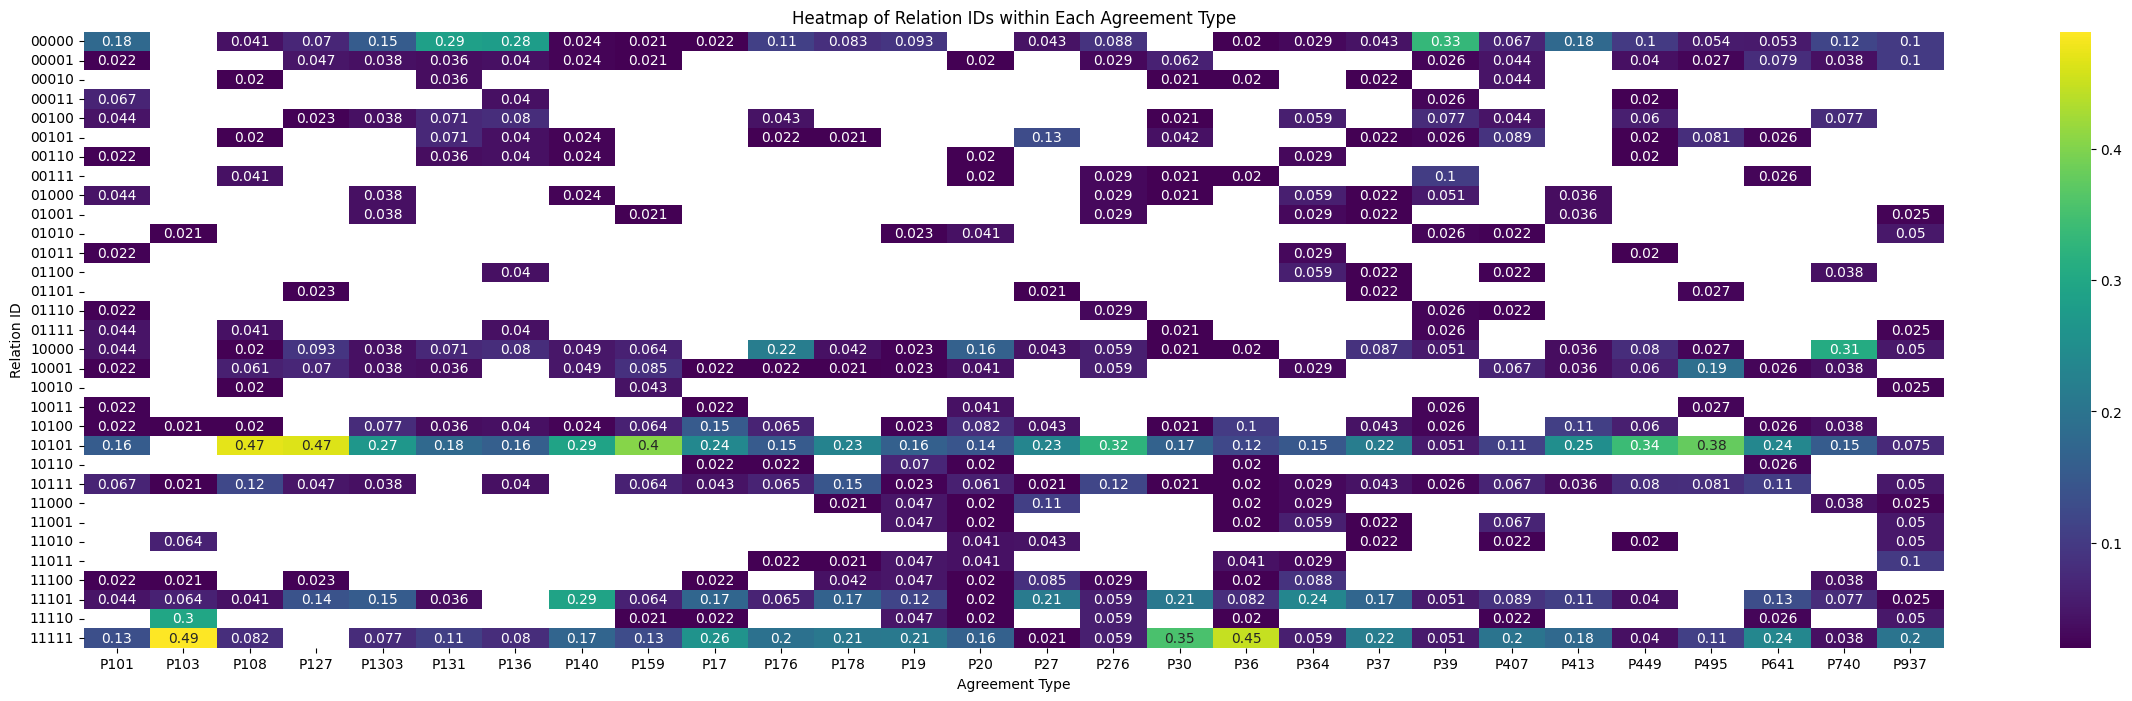

In [22]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a heatmap for the relation_ids DataFrame
plt.figure(figsize=(30, 8))
sns.heatmap(top_relation_ids, annot=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Relation IDs within Each Agreement Type')
plt.xlabel('Agreement Type')
plt.ylabel('Relation ID')
plt.show()